# Import Dependensi dan Variabel

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [383]:
from variabel import variabel as var

# Import Data

In [384]:
df_gravimetri = pd.read_csv('hasil/ET Aktual Gravimetri.csv')
df_bc = pd.read_csv('hasil/Estimasi ET Blaney-Criddle.csv')
df_hs = pd.read_csv('hasil/Estimasi ET Hargreaves-Samani.csv')
df_pm = pd.read_csv('hasil/Estimasi ET Penman-Monteith.csv')

# Plot Gravimetri

In [385]:
df_gravimetri.head()

,Num Day,A1,A2,A3,A4,B1,B2,B3,B4,C1,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
0,day 05,34.176,25.744,34.384,39.728,19.077778,25.144444,23.277778,20.333333,41.787755,...,28.01250,34.73125,11.718519,24.419753,19.170370,20.735802,11.836,13.580,14.316,9.660
1,day 06,2.014,8.190,6.526,10.334,10.207778,7.541111,7.096667,6.096667,8.225918,...,8.69250,3.26750,3.091728,6.301605,2.380617,6.439877,1.490,2.658,1.930,4.378
2,day 07,17.824,18.736,10.944,12.256,11.044444,13.400000,12.000000,10.711111,9.551020,...,14.47500,8.80000,8.918519,11.111111,9.392593,8.790123,2.104,4.408,5.376,6.472
3,day 08,15.648,12.272,10.368,14.928,17.511111,14.755556,9.777778,15.077778,8.669388,...,7.82500,15.31250,3.644444,12.577778,5.985185,13.940741,9.588,7.948,5.912,1.200
4,day 09,17.282,17.266,16.738,16.050,19.523333,19.790000,19.223333,17.756667,18.665510,...,18.14625,16.04000,17.376420,16.615926,15.080123,17.801111,7.630,10.062,7.178,13.874


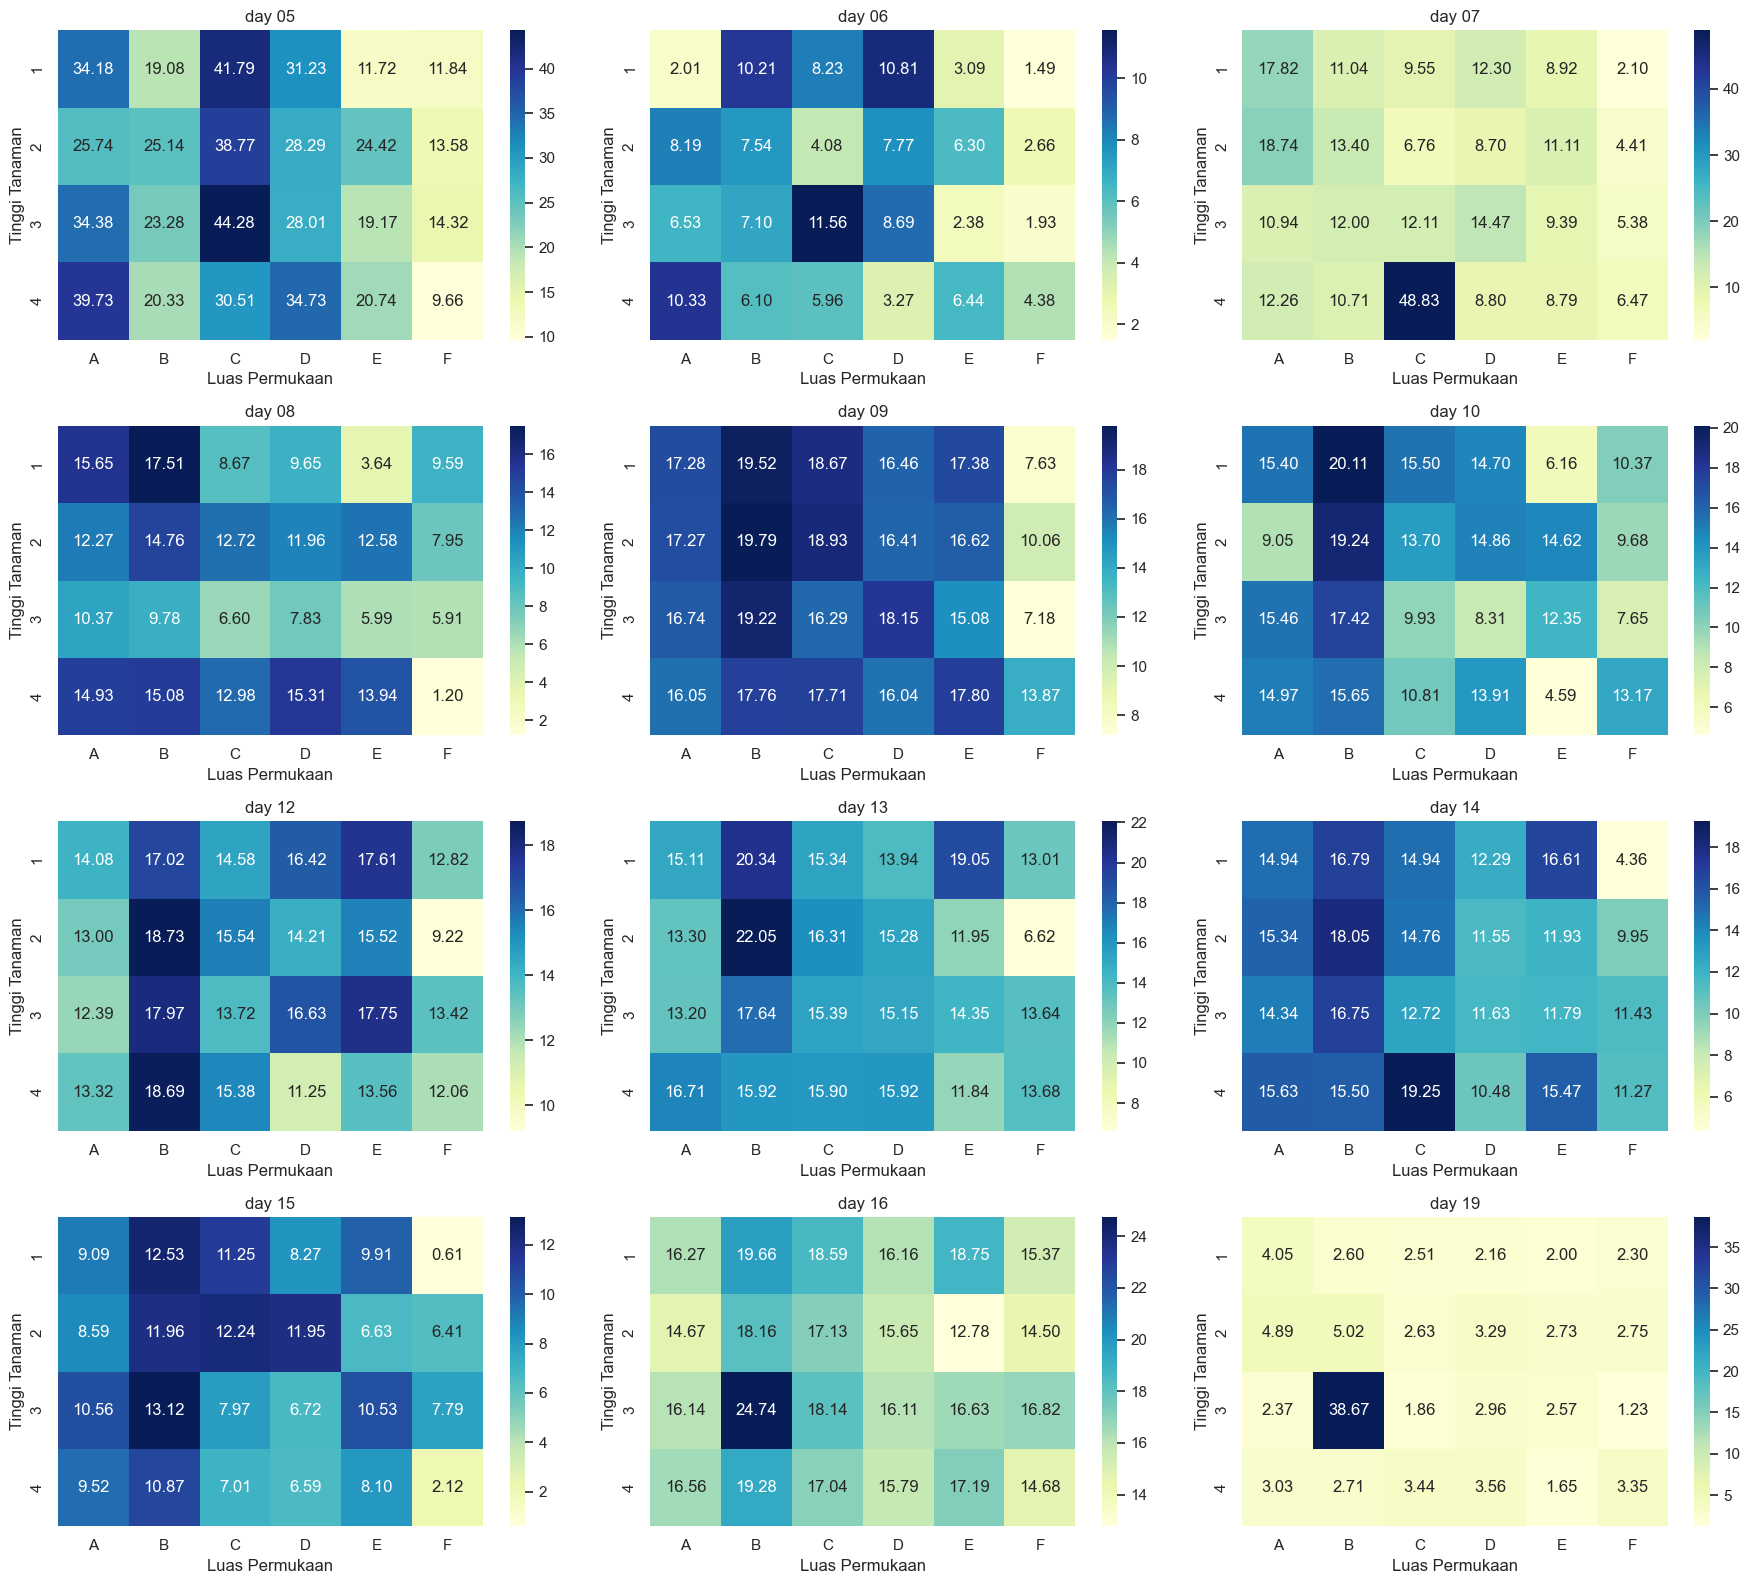

In [386]:
# 1. Mengatur 'Num Day' sebagai index
df_gravimetri = df_gravimetri.set_index('Num Day')

# 2. Mendapatkan sumbu X (karakter pertama dari kode) dan sumbu Y (karakter kedua dari kode)
columns = df_gravimetri.columns

# Mendapatkan karakter pertama (A, B, C, D...) dan karakter kedua (1, 2, 3...)
x_labels = sorted(set(col[0] for col in columns))  # Karakter pertama, misalnya A, B, C...
y_labels = sorted(set(col[1] for col in columns))  # Karakter kedua, misalnya 1, 2, 3...

# 3. Menyiapkan plot untuk subplot
n_days = len(df_gravimetri)  # Jumlah hari yang ada di df_gravimetri
ncols = 3  # Menentukan jumlah kolom
nrows = int(np.ceil(n_days / ncols))  # Menentukan jumlah baris berdasarkan jumlah hari

# Membuat gridspec untuk kontrol lebih baik pada ukuran subplot
fig = plt.figure(figsize=(18, 4 * nrows))  # Ukuran keseluruhan figure
spec = plt.GridSpec(nrows, ncols, figure=fig)

# 4. Membuat subplot heatmap untuk setiap "day"
for i, (day, row) in enumerate(df_gravimetri.iterrows()):
    # Membuat matriks heatmap untuk setiap hari
    day_matrix = []
    for y in y_labels:  # Iterasi berdasarkan karakter kedua (1, 2, 3...)
        row_values = []
        for x in x_labels:  # Iterasi berdasarkan karakter pertama (A, B, C...)
            col_name = f"{x}{y}"  # Membentuk nama kolom seperti A1, B1, C1, ...
            row_values.append(row[col_name])  # Ambil nilai dari baris hari tersebut
        day_matrix.append(row_values)

    # Menentukan lokasi subplot dalam grid dengan `spec[i]`
    ax = fig.add_subplot(spec[i])

    # Plot heatmap untuk setiap hari pada subplot yang sesuai
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)

    # Menambahkan judul setiap subplot dengan hari terkait
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()


# Plot Metode Estimasi

## Blaney-Criddle

In [387]:
df_bc.head(3)

,Num Day,Tanggal,Mean Suhu Udara,ET Total
0,day 05,2024-10-26,30.90750,5.998712
1,day 06,2024-10-27,31.77875,6.106921
2,day 07,2024-10-28,32.63000,6.212646


## Hargreaves-Samani

In [388]:
df_hs.head(3)

,Num Day,Tanggal,Max Suhu Udara,Min Suhu Udara,Mean Suhu Udara,Radiasi Extrateresterial,ET Total
0,day 05,2024-10-26,33.07,25.59,29.330,15.792283,4.681888
1,day 06,2024-10-27,34.18,25.99,30.085,15.798661,4.979544
2,day 07,2024-10-28,35.19,26.08,30.635,15.804507,5.314070


## Penman-Monteith

In [389]:
df_pm.head(3)

,Num Day,Tanggal,Max Suhu Udara,Min Suhu Udara,Mean Suhu Udara,Mean Kecepatan Angin,Mean Kelembapan Relatif,Radiasi Extrateresterial,ET Total
0,day 05,2024-10-26,33.07,25.59,29.330,3.80000,48.86750,15.792283,4.104162
1,day 06,2024-10-27,34.18,25.99,30.085,2.74875,45.59375,15.798661,3.876762
2,day 07,2024-10-28,35.19,26.08,30.635,2.78875,42.54750,15.804507,4.293068


## Plot Estimasi ET

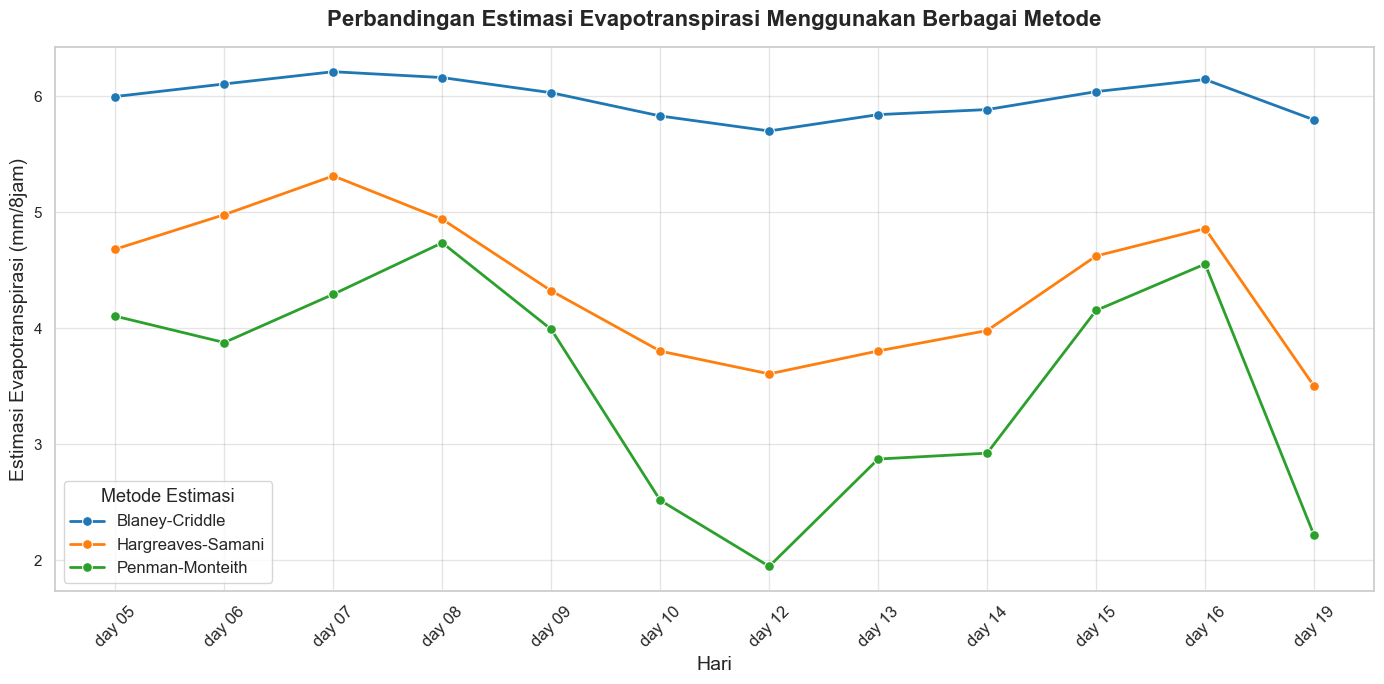

In [390]:
sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(14, 7))

# Plot data Blaney-Criddle
sns.lineplot(
  x=df_bc['Num Day'], y=df_bc['ET Total'], marker='o', label='Blaney-Criddle', color='#1f77b4', markersize=7, linewidth=2)

# Plot data Hargreaves-Samani
sns.lineplot(x=df_hs['Num Day'], y=df_hs['ET Total'], marker='o', label='Hargreaves-Samani', color='#ff7f0e', markersize=7, linewidth=2)

# Plot data Penman-Monteith dengan
sns.lineplot(x=df_pm['Num Day'], y=df_pm['ET Total'], marker='o', label='Penman-Monteith', color='#2ca02c', markersize=7, linewidth=2)

plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=16, weight='bold', pad=15)
plt.xlabel('Hari', fontsize=14)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)

plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(
  title='Metode Estimasi', 
  fontsize=12, 
  title_fontsize='13', 
  frameon=True
)

plt.tight_layout()
plt.show()

# Analisis Parameter

In [391]:
# Data aktual dan estimasi
aktual = df_gravimetri
estimasi_bc = df_bc['ET Total']
estimasi_hs = df_hs['ET Total']
estimasi_pm = df_pm['ET Total']

In [392]:
# Pastikan kolom aktual adalah numerik
aktual = aktual.apply(pd.to_numeric, errors='coerce')

# Pastikan estimasi juga numerik
estimasi_bc = np.array(estimasi_bc, dtype=float)
estimasi_hs = np.array(estimasi_hs, dtype=float)
estimasi_pm = np.array(estimasi_pm, dtype=float)


## Akurasi

In [393]:
# Fungsi menghitung akurasi
def akurasi(aktual, estimasi):
  akurasi = np.mean(estimasi / aktual) * 100
  return akurasi

In [394]:
akurasi_bc = {}
akurasi_hs = {}
akurasi_pm = {}

for col in aktual.columns:
    akurasi_bc[col] = akurasi(aktual[col], estimasi_bc)
    akurasi_hs[col] = akurasi(aktual[col], estimasi_hs)
    akurasi_pm[col] = akurasi(aktual[col], estimasi_pm)

df_akurasi = pd.DataFrame({
    'akurasi BC': akurasi_bc,
    'akurasi HS': akurasi_hs,
    'akurasi PM': akurasi_pm
}).T

df_akurasi.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
akurasi BC,69.467732,53.138738,64.361171,54.169147,53.534981,45.260516,39.778451,58.859816,60.716401,66.513999,...,63.674287,69.295143,91.581626,65.761500,82.221904,82.488841,204.888416,97.444912,121.805566,128.362016
akurasi HS,51.381508,37.963715,45.325527,38.125935,37.550851,32.758864,29.894942,41.791913,42.892349,47.919633,...,45.138853,50.502599,66.234116,46.814634,60.168213,57.032436,154.911608,71.361618,87.177868,97.024278
akurasi PM,39.916298,29.669724,34.602977,29.247894,28.569239,25.719679,24.335843,32.055013,32.939023,36.710432,...,35.197939,39.204831,51.915902,36.361002,47.054228,42.432504,127.803947,55.777774,66.662848,82.975365


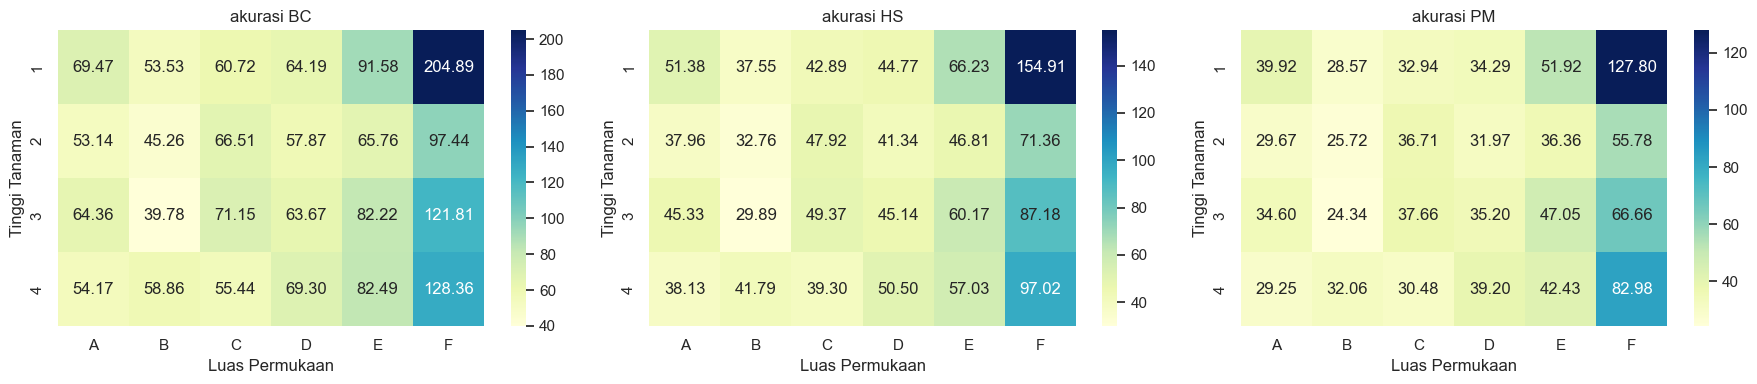

In [401]:
# 2. Mendapatkan sumbu X dan Y (karakter pertama dan kedua dari kode)
x_labels = sorted(set(col[0] for col in df_akurasi.columns))  # Karakter pertama (A, B, C...)
y_labels = sorted(set(col[1] for col in df_akurasi.columns))  # Karakter kedua (1, 2, 3...)

# 3. Membuat subplot heatmap untuk setiap "day"
n_days = len(df_akurasi)  # Jumlah baris di df_akurasi (setiap baris mewakili satu hari)
ncols, nrows = 3, int(np.ceil(n_days / ncols))  # Tentukan jumlah kolom dan baris
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))  # Membuat subplot secara langsung

# 4. Loop untuk membuat heatmap setiap hari
for i, (day, row) in enumerate(df_akurasi.iterrows()):
    ax = axes.flatten()[i]  # Ambil subplot sesuai index
    day_matrix = np.array([[row[f"{x}{y}"] for x in x_labels] for y in y_labels])  # Matriks heatmap
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()


## Mean Absolute Error (MAE)

In [395]:
mae_bc = {}
mae_hs = {}
mae_pm = {}

# Menghitung MSE untuk setiap kolom
for col in aktual.columns:
    mae_bc[col] = mean_absolute_error(aktual[col], estimasi_bc)
    mae_hs[col] = mean_absolute_error(aktual[col], estimasi_bc)
    mae_pm[col] = mean_absolute_error(aktual[col], estimasi_bc)

df_mae = pd.DataFrame({
    'MAE BC': mae_bc,
    'MAE HS': mae_hs,
    'MAE PM': mae_pm
}).T

df_mae.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
MAE BC,9.649147,7.59166,8.210104,9.734327,10.087512,10.302789,12.15999,8.586211,9.53532,9.350181,...,7.381754,7.837022,6.812934,6.796977,6.706144,6.593585,4.840578,3.551921,4.549649,5.023476
MAE HS,9.649147,7.59166,8.210104,9.734327,10.087512,10.302789,12.15999,8.586211,9.53532,9.350181,...,7.381754,7.837022,6.812934,6.796977,6.706144,6.593585,4.840578,3.551921,4.549649,5.023476
MAE PM,9.649147,7.59166,8.210104,9.734327,10.087512,10.302789,12.15999,8.586211,9.53532,9.350181,...,7.381754,7.837022,6.812934,6.796977,6.706144,6.593585,4.840578,3.551921,4.549649,5.023476


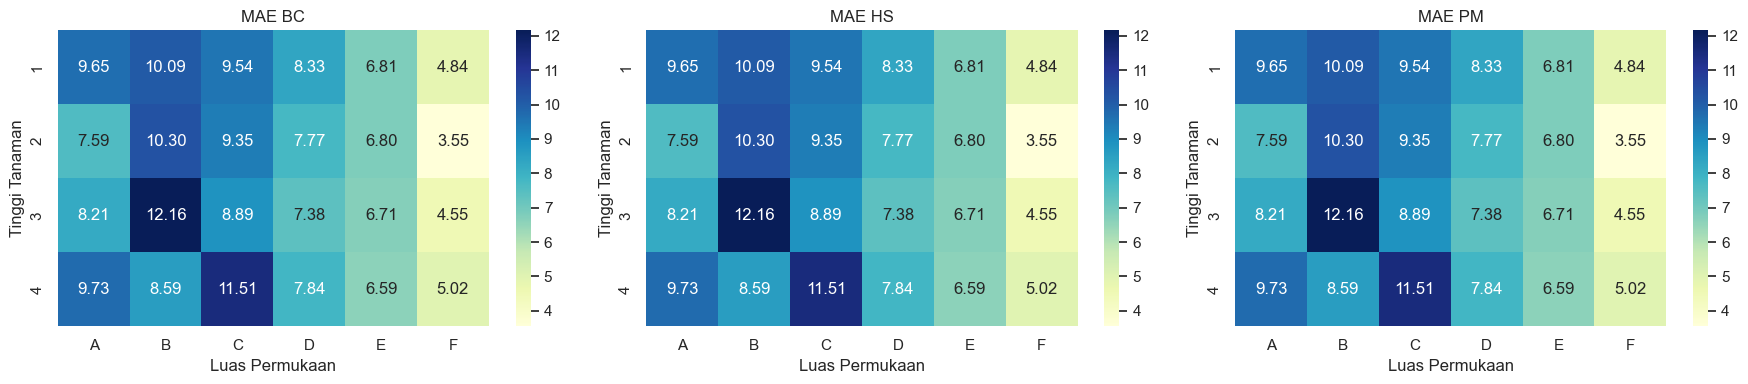

In [396]:
# 2. Mendapatkan sumbu X dan Y (karakter pertama dan kedua dari kode)
x_labels = sorted(set(col[0] for col in df_mae.columns))  # Karakter pertama (A, B, C...)
y_labels = sorted(set(col[1] for col in df_mae.columns))  # Karakter kedua (1, 2, 3...)

# 3. Membuat subplot heatmap untuk setiap "day"
n_days = len(df_mae)  # Jumlah baris di df_mae (setiap baris mewakili satu hari)
ncols, nrows = 3, int(np.ceil(n_days / ncols))  # Tentukan jumlah kolom dan baris
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))  # Membuat subplot secara langsung

# 4. Loop untuk membuat heatmap setiap hari
for i, (day, row) in enumerate(df_mae.iterrows()):
    ax = axes.flatten()[i]  # Ambil subplot sesuai index
    day_matrix = np.array([[row[f"{x}{y}"] for x in x_labels] for y in y_labels])  # Matriks heatmap
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()


# Root Mean Square Error (RMSE)

In [397]:
rmse_bc = {}
rmse_hs = {}
rmse_pm = {}

# Menghitung RMSE untuk setiap kolom
for col in aktual.columns:
    rmse_bc[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_bc))
    rmse_hs[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_hs))
    rmse_pm[col] = np.sqrt(mean_squared_error(aktual[col], estimasi_pm))

# Membuat dataframe untuk RMSE
df_rmse = pd.DataFrame({
    'RMSE BC': rmse_bc,
    'RMSE HS': rmse_hs,
    'RMSE PM': rmse_pm
}).T

# Menampilkan hasil
df_rmse.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
RMSE BC,11.569837,9.142686,10.629284,12.423401,10.870354,11.631772,14.543849,9.605301,12.908959,12.260409,...,9.407848,10.571939,8.185031,8.255451,7.717093,7.945096,5.309824,4.237990,5.634649,5.639199
RMSE HS,12.780536,10.424534,11.805317,13.616169,12.322481,13.093153,16.048277,11.005881,14.050024,13.419539,...,10.606137,11.675557,9.376733,9.531827,8.988718,9.121875,6.104109,5.272522,6.663277,6.735958
RMSE PM,13.412458,11.125310,12.420931,14.243394,13.060499,13.847511,16.831317,11.724227,14.643011,13.991035,...,11.272633,12.225081,10.012573,10.224048,9.674290,9.710651,6.591639,5.847642,7.255886,7.396681


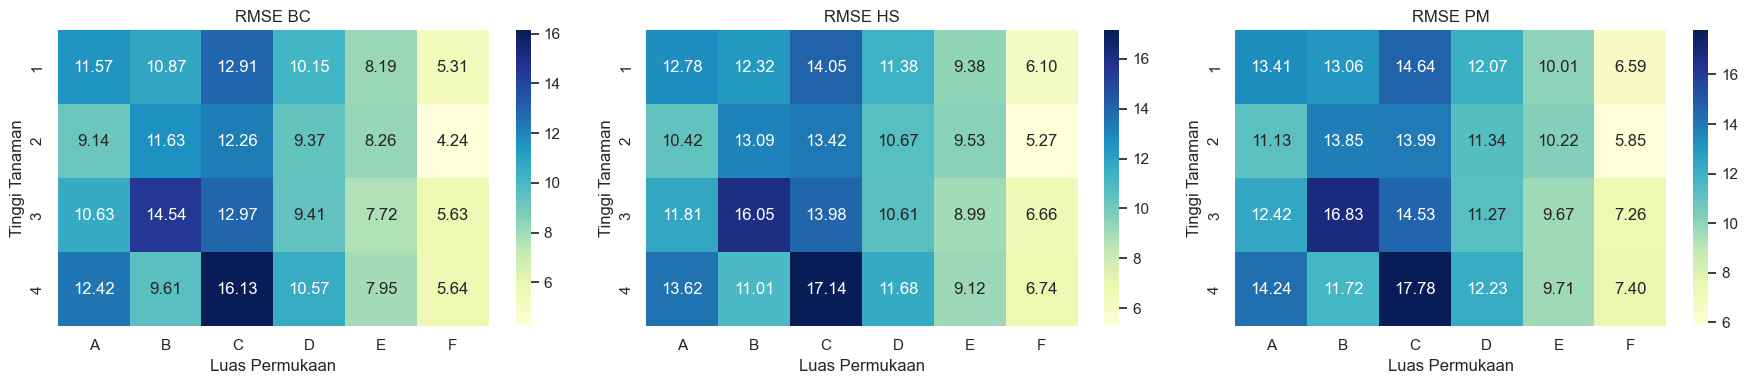

In [398]:
# 2. Mendapatkan sumbu X dan Y (karakter pertama dan kedua dari kode)
x_labels = sorted(set(col[0] for col in df_rmse.columns))  # Karakter pertama (A, B, C...)
y_labels = sorted(set(col[1] for col in df_rmse.columns))  # Karakter kedua (1, 2, 3...)

# 3. Membuat subplot heatmap untuk setiap "day"
n_days = len(df_rmse)  # Jumlah baris di df_rmse (setiap baris mewakili satu hari)
ncols, nrows = 3, int(np.ceil(n_days / ncols))  # Tentukan jumlah kolom dan baris
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))  # Membuat subplot secara langsung

# 4. Loop untuk membuat heatmap setiap hari
for i, (day, row) in enumerate(df_rmse.iterrows()):
    ax = axes.flatten()[i]  # Ambil subplot sesuai index
    day_matrix = np.array([[row[f"{x}{y}"] for x in x_labels] for y in y_labels])  # Matriks heatmap
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()


# Mean Bias Error (MBE)

In [399]:
mbe_bc = {}
mbe_hs = {}
mbe_pm = {}

# Menghitung MBE untuk setiap kolom
for col in aktual.columns:
    mbe_bc[col] = np.mean(aktual[col] - estimasi_bc)
    mbe_hs[col] = np.mean(aktual[col] - estimasi_hs)
    mbe_pm[col] = np.mean(aktual[col] - estimasi_pm)

# Membuat dataframe untuk MBE
df_mbe = pd.DataFrame({
    'MBE BC': mbe_bc,
    'MBE HS': mbe_hs,
    'MBE PM': mbe_pm
}).T

# Menampilkan hasil
df_mbe.head()


,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
MBE BC,8.676434,7.439768,7.638657,9.273101,9.554434,10.173416,12.159990,8.069944,8.988108,8.484026,...,6.908862,6.990893,5.257727,6.285710,5.518015,5.696821,1.644601,2.168434,2.910712,2.847601
MBE HS,10.288230,9.051564,9.250452,10.884897,11.166230,11.785212,13.771786,9.681739,10.599904,10.095822,...,8.520657,8.602689,6.869522,7.897506,7.129810,7.308617,3.256397,3.780230,4.522508,4.459397
MBE PM,11.141256,9.904589,10.103478,11.737922,12.019256,12.638237,14.624811,10.534765,11.452929,10.948847,...,9.373683,9.455714,7.722548,8.750531,7.982836,8.161642,4.109422,4.633256,5.375533,5.312422


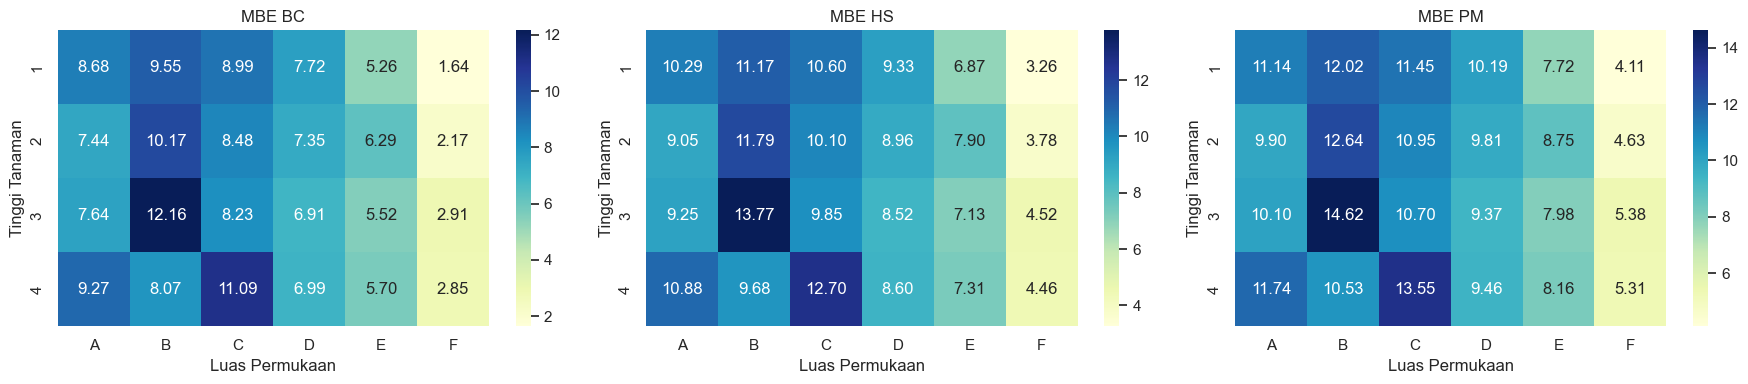

In [400]:
# 2. Mendapatkan sumbu X dan Y (karakter pertama dan kedua dari kode)
x_labels = sorted(set(col[0] for col in df_mbe.columns))  # Karakter pertama (A, B, C...)
y_labels = sorted(set(col[1] for col in df_mbe.columns))  # Karakter kedua (1, 2, 3...)

# 3. Membuat subplot heatmap untuk setiap "day"
n_days = len(df_mbe)  # Jumlah baris di df_mbe (setiap baris mewakili satu hari)
ncols, nrows = 3, int(np.ceil(n_days / ncols))  # Tentukan jumlah kolom dan baris
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))  # Membuat subplot secara langsung

# 4. Loop untuk membuat heatmap setiap hari
for i, (day, row) in enumerate(df_mbe.iterrows()):
    ax = axes.flatten()[i]  # Ambil subplot sesuai index
    day_matrix = np.array([[row[f"{x}{y}"] for x in x_labels] for y in y_labels])  # Matriks heatmap
    sns.heatmap(day_matrix, cmap='YlGnBu', xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'{day}')
    ax.set_xlabel('Luas Permukaan')
    ax.set_ylabel('Tinggi Tanaman')

# Menyesuaikan tampilan plot
plt.tight_layout()
plt.show()
